In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def process(path):
    """
    pre-processing TRI data
    for train set (1997-2020): 1.eliminate extreme values; 2. standardization
    for test set (2020-2022): rolling window standardization
    """
    df = pd.read_csv(path)
    tri = df.tri.values
    split_node = df[df['timestamp'].str.contains('2019')].index[-1]
    train = tri[:split_node+1]
    test = tri[split_node+1:]
    train = process_extreme_MAD(train).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = rolling_standard(train.ravel(), test)
    return train, test
    
    
def process_extreme_MAD(array, n=3):
    """
    Deal with extreme values, use MAD method
    """
    mid = np.median(array)
    mid1 = np.median(np.abs(array - mid))
    maximum = mid + n * mid1
    minimum = mid - n * mid1
    return np.clip(array, minimum, maximum)
    

def rolling_standard(pre, cur, n=60):
    """
    rolling window standardization
    """
    new = np.concatenate([pre[-(n-1):], cur])
    df = pd.DataFrame(new)
    mean = df.rolling(n).apply(np.mean)
    std = df.rolling(n).apply(np.std)
    df1 = (df - mean) / std
    return df1[(n-1):].values
path = '/Users/wangsizhe/Desktop/AUD_v2.csv'
train,test = process(path)

In [69]:
training_set_scaled = train
testing_set_scaled = test

In [71]:
import pandas as pd 
 
# 加载数据集 
data = pd.read_csv('/Users/wangsizhe/Desktop/AUD_v2.csv')
data.drop(['underlyer','spot','carry','active','version'],axis=1,inplace=True)
 
# 将日期设置为索引 
data = data.set_index('timestamp')
# 显示前5行数据 
print(data.head()) 

                          tri
timestamp                    
1997-03-19 19:00:00  0.000000
1997-03-20 19:00:00  0.090012
1997-03-21 19:00:00 -0.172836
1997-03-24 19:00:00  0.163459
1997-03-25 19:00:00  0.133008


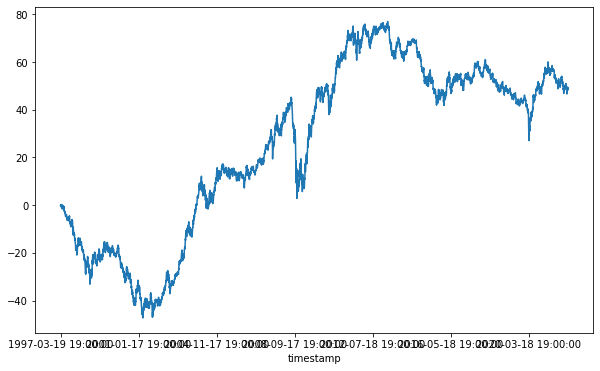

In [72]:
import matplotlib.pyplot as plt 
 
# 绘制销售额随时间的变化图 
series = data
plt.figure(figsize=(10, 6))
 
series['tri'].plot()
plt.show()

In [73]:
# training_set = data.values
# # 训练数据max-min归一化
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set)


In [74]:
# 每条样本含60个时间步，对应下一时间步的标签值
X_train = []
y_train = []
for i in range(12, 5512):
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
 
print(X_train.shape)
print(y_train.shape)
 
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)


(5500, 1)
(5500,)
(5500, 1, 1)


In [75]:
X_test = []
y_test = []
for i in range(12, 540):
    X_test.append(testing_set_scaled[i-1:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(528, 1, 1)


In [76]:
#  利用Keras创建RNN模型
 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM
from keras.layers import Dropout
 
 
# 初始化顺序模型
regressor = Sequential()
 
# 定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 5, input_shape = (X_train.shape[1], 1)))
 
# 定义线性的输出层
regressor.add(Dense(units = 1))
 
# 模型编译：定义优化算法adam， 目标函数均方根MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
# 模型训练
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 100, validation_split=0.1)
 
regressor.summary()


Epoch 1/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2336 - val_loss: 0.1161
Epoch 2/100
50/50 [==============================] - 0s 927us/step - loss: 0.1044 - val_loss: 0.0385
Epoch 3/100
50/50 [==============================] - 0s 757us/step - loss: 0.0399 - val_loss: 0.0067
Epoch 4/100
50/50 [==============================] - 0s 750us/step - loss: 0.0141 - val_loss: 3.8923e-04
Epoch 5/100
50/50 [==============================] - 0s 767us/step - loss: 0.0063 - val_loss: 0.0013
Epoch 6/100
50/50 [==============================] - 0s 763us/step - loss: 0.0046 - val_loss: 0.0030
Epoch 7/100
50/50 [==============================] - 0s 831us/step - loss: 0.0042 - val_loss: 0.0033
Epoch 8/100
50/50 [==============================] - 0s 743us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 9/100
50/50 [==============================] - 0s 761us/step - loss: 0.0040 - val_loss: 0.0032
Epoch 10/100
50/50 [==============================] - 0s 780us/step - loss: 0.0039 - val_

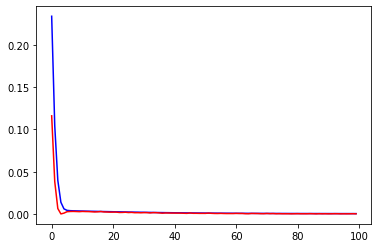

In [77]:
plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()


In [78]:
real_stock_price = y_test

In [79]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(1,-1)[0]
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

17/17 [==============================] - 0s 567us/step
预测与实际差异MSE 0.12319220642053948
预测与实际差异MAE 0.25005136850512255


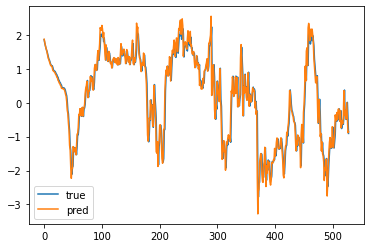

In [80]:
plt.plot(predicted_stock_price)
plt.plot(real_stock_price)
plt.legend(['true','pred'])
plt.show()

In [81]:
a = y_test[:-1]
b = predicted_stock_price[1:]
c = np.diff(y_test)
out = np.logical_or(
                    np.logical_and((b-a < 0),(c < 0)), 
                    np.logical_and((b-a > 0),(c > 0))
                                             )
sum(out)/len(a)

0.5047438330170778